<a href="https://colab.research.google.com/github/astromad/MyDeepLearningRepo/blob/master/AutoEncoder_Gray2RGB_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                        


 **Autoencoders**




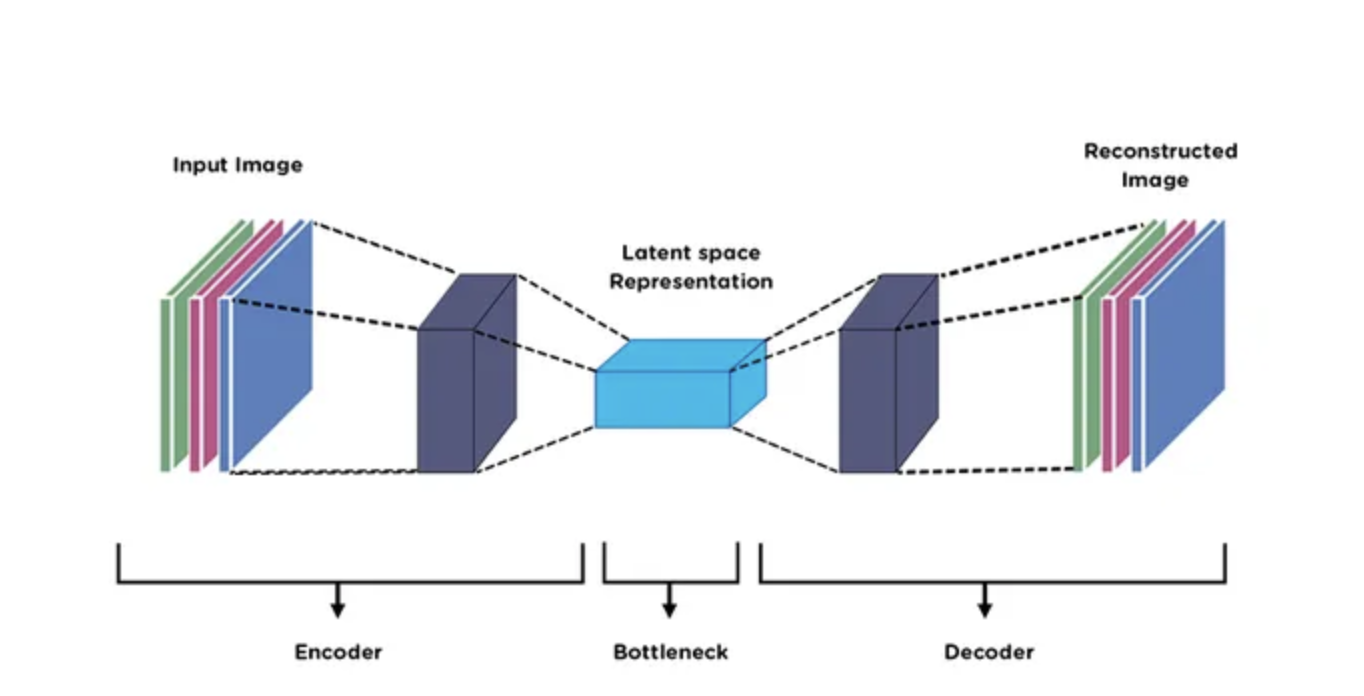

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import fnmatch


In [ ]:
# print("Tensorflow version " + tf.__version__)
# if tf.config.list_physical_devices('GPU'):
#   # strategy = tf.distribute.MirroredStrategy()
#   strategy = tf.distribute.MirroredStrategy()
#     # cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
#     #devices=["GPU:1"],
#     # #cross_device_ops=tf.distribute.ReductionToOneDevice(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#     # cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
#     # )
# else:  # Use the Default Strategy
#   strategy = tf.distribute.get_strategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [ ]:
imgpath = '/content/drive/MyDrive/ColabData/Gray2RGB/AstroDataset/'
testimgpath = '/content/drive/MyDrive/ColabData/Gray2RGB/TESTIMAGES/'
modelpath = '/content/drive/MyDrive/ColabData/Gray2RGB/models/'

In [ ]:
vggmodel = tf.keras.applications.vgg16.VGG16(weights='imagenet')
newmodel = tf.keras.models.Sequential()
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(7, 7, 512)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.UpSampling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.UpSampling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.UpSampling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.UpSampling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.UpSampling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model


In [ ]:
model = create_model()
model.compile(optimizer='Adam', loss='mse' )
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 7, 7, 64)          294976    
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 up_sampling2d_5 (UpSamplin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 28, 28, 128)       0         
 g2D)                                                 

In [ ]:
class train_print_cb(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))
    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Epoc ended; got log keys: {}".format(keys))
        watch = keys[0] ## watching the first key, usually the loss
        print(f'epoch {epoch} {watch}: {logs[watch]:.3f}          ', end = '\r')
    def on_epoch_start(self, epoch, logs=None):
        keys = list(logs.keys())
        watch = keys[0] ## watching the first key, usually the loss
        print(f'epoch {epoch} started', end = '\r')


In [ ]:
Y_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./255,dtype=np.float32)

In [ ]:
BATCH_SIZE=64
gen=Y_datagen.flow_from_directory(imgpath,classes=None,class_mode=None,target_size=(224, 224),batch_size=BATCH_SIZE,color_mode='rgb')

Found 1882 images belonging to 1 classes.


In [ ]:
def image_a_b_gen1():
    for batch in gen:
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0] /100
        X_batch=gray2rgb(X_batch)
        bs,x,y,z=X_batch.shape
        X_batch=newmodel.predict(X_batch.reshape((bs,224,224,3)))
        X_batch=np.array(X_batch.reshape((bs,7,7,512)))
        Y_batch = np.array(lab_batch[:,:,:,1:] / 128)
        yield (X_batch,Y_batch)

Learning rate per epoch:


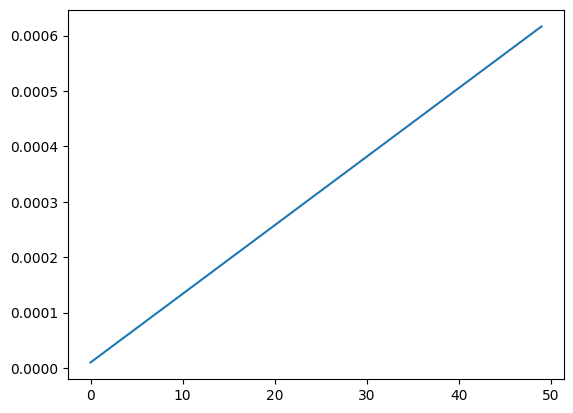

In [ ]:
import matplotlib.pyplot as plt
import math
EPOCHS = 50

start_lr = 0.00001
min_lr = 0.0000001
max_lr = 0.001
rampup_epochs = 80
sustain_epochs = 20
k = 0.8
exp_decay = start_lr * math.exp(-k*EPOCHS)

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:

steps_per_epoch = gen.samples //  BATCH_SIZE
print ('Steps per EPOCH',steps_per_epoch)

Steps per EPOCH 29


In [ ]:
model = tf.keras.models.load_model(modelpath+'/AutoEncoder_Gray2RGB_Generator.model',
                                     custom_objects=None,
                                     compile=True)

In [ ]:
epoc_callback = train_print_cb()

history=model.fit(x=image_a_b_gen1(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,callbacks=[lr_callback,epoc_callback],verbose=1)

In [ ]:
model.save(modelpath+'/AutoEncoder_Gray2RGB_Generator.model')

In [ ]:
model = tf.keras.models.load_model(modelpath+'/AutoEncoder_Gray2RGB_Generator.model',
                                     custom_objects=None,
                                     compile=True)

0 wow.jpg
('wow', '.jpg')


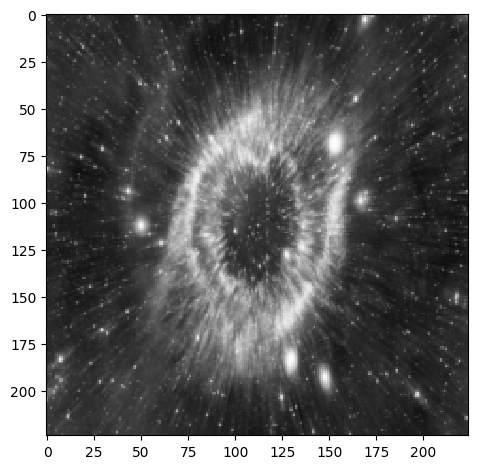

Image sent shape (1, 224, 224, 3)
1/1 [==============================] - 0s 132ms/step
Image received from vgg shape (1, 7, 7, 512)
1/1 [==============================] - 0s 138ms/step
Output Image received from main shape (224, 224, 2)


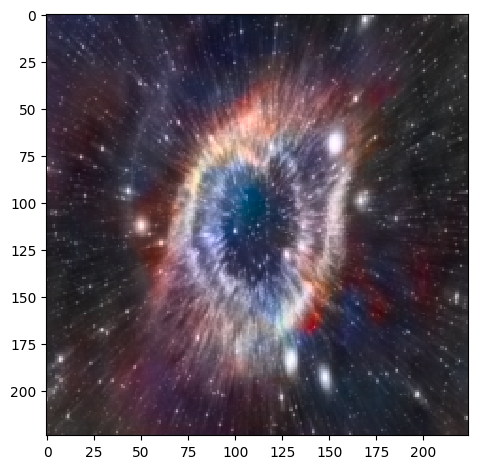

1 OUTPUT
2 .ipynb_checkpoints


In [ ]:
from google.colab.patches import cv2_imshow
from skimage.io import imshow
from skimage import exposure
testpath=testimgpath
outpath=testpath+'OUTPUT/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
  print(idx,file)
  if(file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))):
    split_tup = os.path.splitext(file)
    print(split_tup)
    test = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(testpath+file),dtype=float)
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0] /100
    L = gray2rgb(l )
    imshow(L)
    plt.show()
    # imsave(outpath+split_tup[0]+'_gray'+ split_tup[1], L.astype(np.uint8))
    imsave(outpath+split_tup[0]+'_gray'+ '.tif', L)
    L = L.reshape((1,224,224,3))
    print('Image sent shape',L.shape)
    vggpred = newmodel.predict(L)
    print('Image received from vgg shape',vggpred.shape)
    ab = model.predict(vggpred)
    print('Output Image received from main shape',ab[0].shape)

    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l * 100
    cur[:,:,1:] = ab[0]

    imshow(lab2rgb(cur))
    plt.show()

    imsave(outpath+split_tup[0]+'_Output'+ '.tif', lab2rgb(cur))
    # imsave(outpath+split_tup[0]+'_Output1'+ split_tup[1], lab2rgb(cur).astype(np.uint8))
